In [1]:
import requests
import io
import datetime

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [2]:
import statsmodels.api as sm

In [3]:
INPUT_DIR = "input/"

In [4]:
df = pd.read_csv(INPUT_DIR + 'weekly.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

In [5]:
df.describe()

,power,power_std
count,257.000000,257.000000
mean,32.513231,2.316009
std,3.657390,0.872325
min,23.457738,0.777094
25%,29.427798,1.677036
50%,31.880714,2.141345
75%,35.298036,2.767801
max,41.931488,5.679354


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 257 entries, 2016-04-04 to 2021-03-01
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   power      257 non-null    float64
 1   power_std  257 non-null    float64
dtypes: float64(2)
memory usage: 6.0 KB


In [7]:
df.head()

,power,power_std
date,,
2016-04-04,29.249286,2.442016
2016-04-11,29.392024,2.068137
2016-04-18,28.636488,1.573074
2016-04-25,28.005298,2.433128
2016-05-02,25.686905,1.276991


In [8]:
def correlation_plot(data, lags=60):
    fig = plt.figure(figsize=(10, 8))
    # 自己相関のコレログラム
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.set_ylim(-1.1, 1.1)
    fig = sm.graphics.tsa.plot_acf(data, lags=lags, ax=ax1)
    # 偏自己相関のコレログラム
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.set_ylim(-1.1, 1.1)    
    fig = sm.graphics.tsa.plot_pacf(data, lags=lags, ax=ax2)
    plt.show()

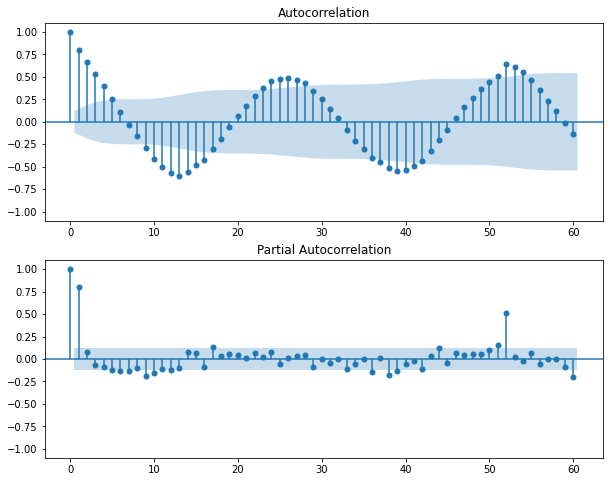

In [9]:
correlation_plot(df['power'])

/home/ryoji/.cache/pypoetry/virtualenvs/timeseries-weK0nu0g-py3.8/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


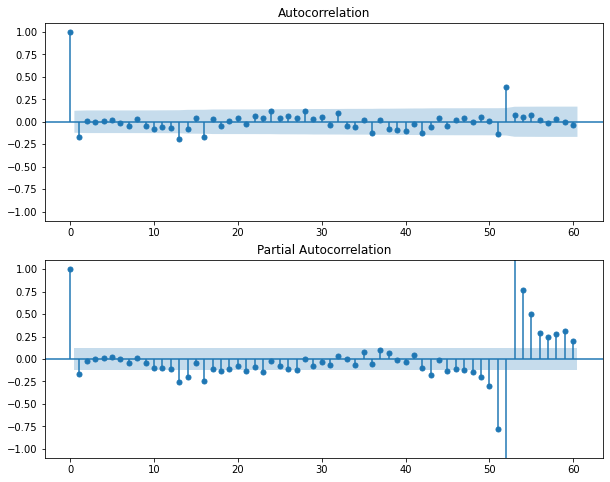

In [10]:
correlation_plot(df['power'].diff().dropna())

In [11]:
from statsmodels.tsa import stattools

---ctt---
(-7.721195782846313, 1.5838433678166987e-09, 12, 244, {'1%': -4.41924725418372, '5%': -3.856811620036479, '10%': -3.568351640145541}, 1050.6339020091987)
---ct---
(-7.603692294199349, 5.880870524981531e-10, 12, 244, {'1%': -3.996359596472282, '5%': -3.428638339811482, '10%': -3.137714188412246}, 1049.8224039548784)
---c---
(-7.57431703710567, 2.7876451886058832e-11, 12, 244, {'1%': -3.457437824930831, '5%': -2.873459364726563, '10%': -2.573122099570008}, 1048.9006469741646)
---nc---
(0.07898432696865158, 0.7099282167491263, 16, 240, {'1%': -2.5751188020833333, '5%': -1.942175328197338, '10%': -1.6157586166087963}, 1071.087997120638)


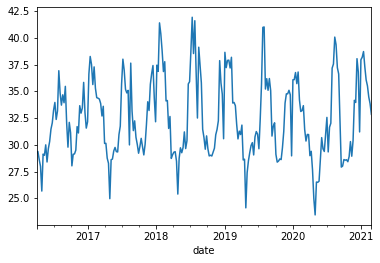

In [12]:
# ARを適用したときに単位根過程であるかを検定。単位根過程（＝非定常過程）だとARを適用できない。
# ｐ値が大きいと、単位根過程であることを棄却できない。すなわち、定常状態ではないと判断する。
y = df['power']
y.plot()
regs = ['ctt', 'ct', 'c', 'nc'] # 2次のトレンド＋定数項、1次のトレンド＋定数項, トレンドなし＋定数項、トレンド・定数項なし
for r in regs:
    print(f'---{r}---')
    print(sm.tsa.stattools.adfuller(y, regression=r))

---ctt---
(-7.898069064786849, 5.915500515896855e-10, 16, 239, {'1%': -4.420267733691505, '5%': -3.857327364754362, '10%': -3.5686694525172613}, 1068.062820745776)
---ct---
(-7.91032468514128, 1.151689946320576e-10, 16, 239, {'1%': -3.99715658668426, '5%': -3.4290213886201637, '10%': -3.137938763154836}, 1066.3274777362158)
---c---
(-7.930428561374686, 3.5251644629832415e-12, 16, 239, {'1%': -3.458010773719797, '5%': -2.8737103617125186, '10%': -2.5732559963936206}, 1064.3305414344197)
---nc---
(-7.949117732761775, 4.2871940983481364e-13, 16, 239, {'1%': -2.5751583085030023, '5%': -1.9421804723277365, '10%': -1.6157543581953568}, 1062.3547061773527)


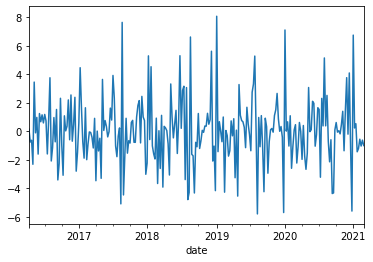

In [13]:
# トレンドはなさそうだが、定数項が無いことはなさそう。階差をとって定数項をなくす。
dy = df['power'].diff().dropna()
dy.plot()
regs = ['ctt', 'ct', 'c', 'nc'] # 2次のトレンド＋定数項、1次のトレンド＋定数項, トレンドなし＋定数項、トレンド・定数項なし
for r in regs:
    print(f'---{r}---')
    print(sm.tsa.stattools.adfuller(dy, regression=r))

Text(0, 0.5, 'Residual')

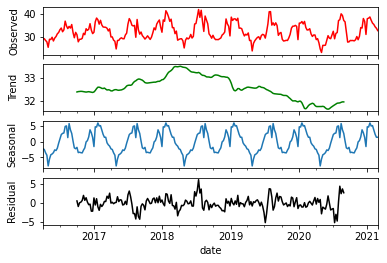

In [14]:
fig, axes = plt.subplots(4, 1, sharex=True)

decomposition = sm.tsa.seasonal_decompose(y, model ='additive')
decomposition.observed.plot(ax=axes[0], legend=False, color='r')
axes[0].set_ylabel('Observed')
decomposition.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Trend')
decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
decomposition.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Residual')

In [15]:
# 考えられるパラメータの組み合わせを全て作成
# 季節階差は52週
max_p = 2 #AR(自己回帰過程)の次数
max_d = 1 #I（和分過程）の次数
max_q = 1 #MA（移動平均過程）の次数
max_sp = 1 #季節階差のAR(自己回帰過程)の次数
max_sd = 1
max_sq = 1
params = []

seasonal = 52

for p in range(0, max_p + 1):
    for d in range(0, max_d + 1): 
        for q in range(0, max_q + 1): 
            for sp in range(0, max_sp + 1):
                for sd in range(0, max_sd + 1): 
                    for sq in range(0, max_sq + 1): 
                        params.append([p,d,q,sp,sd,sq])

params[:3]

[[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 0]]

In [16]:
# テストするため, 学習用とテスト用データの分割

num = len(y)
n_test = seasonal

y_train, y_test = y.head(num - n_test), y.tail(n_test)

# AIC計算用のメソッドを作成
def aic_calculater(param):
    aic = sm.tsa.statespace.SARIMAX(
                                endog=y_train, trend="n", order=(param[0], param[1], param[2]),
                                seasonal_order=(param[3], param[4], param[5], seasonal), enforce_invertibility = False, enforce_stationarity = False).fit().aic
    return aic
 
# 並列計算: n_jobs=-1とするとCPUコア数の数だけ並列化される
import joblib
aic_list = joblib.Parallel(n_jobs=-1, verbose=10)([joblib.delayed(aic_calculater)(param) for param in params])
 
# AICが小さくなる順にのパラメータの組み合わせを並べ変え
aic_df = pd.DataFrame({"params": params, "aic": aic_list})
aic_df.sort_values("aic", inplace=True)
aic_df.head(10)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  91 out of  96 | elapsed:   18.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   23.2s finished


,params,aic
59,"[1, 1, 1, 0, 1, 1]",395.956692
43,"[1, 0, 1, 0, 1, 1]",397.035966
91,"[2, 1, 1, 0, 1, 1]",398.005674
35,"[1, 0, 0, 0, 1, 1]",398.018594
75,"[2, 0, 1, 0, 1, 1]",399.008635
67,"[2, 0, 0, 0, 1, 1]",400.018461
11,"[0, 0, 1, 0, 1, 1]",406.221657
27,"[0, 1, 1, 0, 1, 1]",408.122214
63,"[1, 1, 1, 1, 1, 1]",409.488537
71,"[2, 0, 0, 1, 1, 1]",409.809234


In [17]:
# AICが最小のパラメータを当てはめる
best_params = aic_df.head(1)['params'].values[0]

model = sm.tsa.statespace.SARIMAX(
                                endog=y_train, trend="n", order=(best_params[0], best_params[1], best_params[2]),
                                seasonal_order=(best_params[3], best_params[4], best_params[5], seasonal), 
    enforce_invertibility = False, enforce_stationarity = False)

results = model.fit()

# テスト期間の予測値を出力する
y_pred = results.get_prediction(
                                start = y_test.index[0],
                                end = y_test.index[-1],
                                dynamic=False)
 
# 点推定での予測値と区間推定での予測値を取り出す
pred_mean = y_pred.predicted_mean
pred_ci = y_pred.conf_int(alpha = .05)

# MAPEを計算する自作関数を定義
def mape(true, pred):
    
    act = list(true)
    preds = list(pred)
    total = 0
    for i in range(len(act)):
        ape = np.abs((act[i] - preds[i])/act[i])
        total += ape
    mape = (total / len(act)) * 100
    
    return mape

# MAPEを算出
print(mape(y_test, pred_mean))


/home/ryoji/.cache/pypoetry/virtualenvs/timeseries-weK0nu0g-py3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/home/ryoji/.cache/pypoetry/virtualenvs/timeseries-weK0nu0g-py3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/home/ryoji/.cache/pypoetry/virtualenvs/timeseries-weK0nu0g-py3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


5.8201833830826


In [27]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              power   No. Observations:                  205
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 52)   Log Likelihood                -193.978
Date:                            Wed, 24 Mar 2021   AIC                            395.957
Time:                                    13:42:58   BIC                            406.297
Sample:                                04-04-2016   HQIC                           400.139
                                     - 03-02-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5733      0.088      6.499      0.000       0.400       0.746
ma.L1         -0.9736      0.040    -24.201      0.000      -1.052      -0.895
ma.S.L52      -1.0001   1877.988     -0.001      1.000   -3681.789    3679.789
sigma2         2.1506   4038.940      0.001      1.000   -7914.025    7918.327
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.67
Prob(Q):                              0.99   Prob(JB):                         0.26
Heteroskedasticity (H):               0.99   Skew:                             0.30
Prob(H) (two-sided):                  0.98   Kurtosis:                         3.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

回帰係数のチェック
ar.L1:一つ前の実績の半分にした値が影響している。
ma.L1:一つ前の誤差のマイナスにしたものが影響している。
ma.S.L52:一つ前の誤差のマイナスにしたものが影響している。が、信頼区間が広すぎる。
sigma2 :信頼区間が広すぎる。

残差のチェック
Jarque-Bera (JB):尖度と歪度による正規性の検定　H0は標本分布が正規分布に従う。
Ljung-Box (L1) (Q)：H0　データは無作為（ラグと相関がないか）
Heteroskedasticity (H):　H0　分散は均一である。

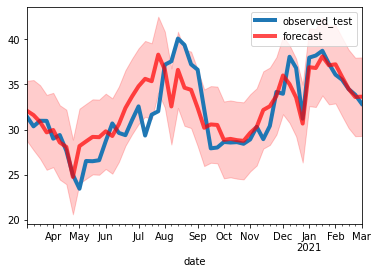

In [38]:
y_test.plot(label='observed_test', linewidth=4)
pred_mean.plot(label='forecast', alpha=.7, color = "r", linewidth=4)
 
# 区間予測の折れ線グラフを描画
plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='r', alpha=.2)
plt.legend()
plt.show()

<AxesSubplot:xlabel='date'>

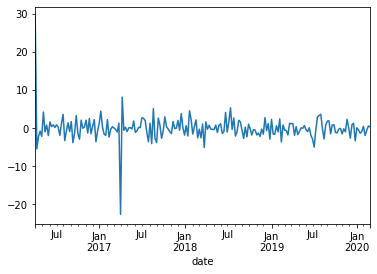

In [39]:
# GWの曜日のズレ？
results.resid.plot()

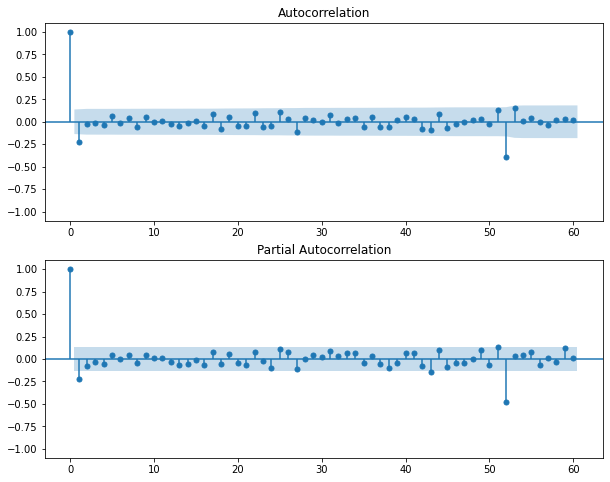

In [34]:
correlation_plot(results.resid)